# Double Debiased Machine Learning (part 1)

*Causal inference, machine learning and regularization bias*

In causal inference, we often estimate causal effects by conditioning the analysis on other variables. We usually refer to these variables as **control variables** or **confounders**. In randomized control trials or AB tests, conditioning can increase the power of the analysis, by reducing imbalances that have emerged despite randomization. However, conditioning is even more important in observational studies, where, absent randomization, it might be [essential to recover causal effects](https://towardsdatascience.com/b63dc69e3d8c).

When we have many control variables, we might want to **select the most relevant ones**, ppossibly capturing nonlinearities and interactions. Machine learning algorithms are perfect for this task. However, in these cases, we are introducing a bias that is called **regularization or pre-test, or feature selection bias**. In this and the next blog post, I try to explain the source of the bias and a very poweful solution called **double debiased machine learning**, which has been probably one of the most relevant advancement at the intersection of machine learning and causal inference of the last decade.

## Pre-Testing

Since this is a complex topic, let's start with a simple example. 

Suppose we were a firm and we are interested in the **effect of advertisement spending on revenue**: is advertisement worth the money? There are also a lot of other things that might influence sales, therefore, we are thinking of controlling for past sales in the analysis, in order to increase the power of our analysis.

Assume the data generating process can be represented with the following [**Directed Acyclic Graph (DAG)**](https://towardsdatascience.com/b63dc69e3d8c). If you are not familiar with DAGs, I have written a short [introduction here](https://towardsdatascience.com/b63dc69e3d8c).

```mermaid
flowchart LR
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;
classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;

D((ad spend))
Z((past sales))
Y((sales))

D --> Y
Z -- ??? --> Y
Z --> D

class D,Y included;
class Z excluded;

linkStyle 0 stroke:#00ff00,stroke-width:4px;
```

I import the data generating process `dgp_tbd()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/src/dgp.py) and some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/src/utils.py).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_pretest

df = dgp_pretest().generate_data()
df.head()

,ads,sales,past_sales
0,16.719800,19.196620,6.624345
1,7.732222,9.287491,4.388244
2,10.923469,11.816906,4.471828
3,8.457062,9.024376,3.927031
4,13.085146,12.814823,5.865408


We have data on $1000$ different markets, in which we observe current `sales`, the amount spent in `advertisement` and `past sales`. 

We want to understand `ads` spending is effective in increasing `sales`. One possibility is to regress the latter on the former, using the following regression model, also called the **short model**.

$$
\text{sales} = \alpha \cdot \text{ads} + \varepsilon
$$

Should we also include `past sales` in the regression? Then the regression model would be the following, also called **long model**.

$$
\text{sales} = \alpha \cdot \text{ads} + \beta \cdot \text{past sales} + \varepsilon
$$

Since we are not sure whether to condition the analysis on `past sales`, we could **let the data decide**: we could run the second regression and, if the effect of `past sales`, $\beta$, is statistically significant, we are good with the long model, otherwise we run the short model.

In [3]:
smf.ols('sales ~ ads + past_sales', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.1405,0.185,0.758,0.448,-0.223,0.504
ads,0.9708,0.030,32.545,0.000,0.912,1.029
past_sales,0.3381,0.095,3.543,0.000,0.151,0.525


It seems that the effect of `past sales` on current `sales` is positive and significant. Therefore, we are happy with our specification and we conclude that the effect of `ads` on `sales` is positive and significant with a 95% confidence interval of $[0.912, 1.029]$.

## The Bias

There is an **issue** with this procedure: we are not taking into account the fact that we have run a test to decide whether to include `past_sales` in the regression. The fact that we have decided to include `past_sales` because its coefficient is significant *does* have an effect on the inference on the effect of `ads` on `sales`, $\alpha$.

The best way to understand the problem is through **simulations**. Since we have access to the data generating process `dgp_pretest()` (unlike in real life), we can just test what would happen if we were repeating this procedure multiple times:

1. We draw a new sample from the data generating process.
2. We regress `sales` on `ads` and `past_sales`.
3. If the coefficient of `past_sales` is significant at the 95% level, we keep $\hat \alpha_{long}$ from (2).
4. Otherwise, we regress `sales` on `ads` only, and we keep that coefficient $\hat \alpha_{short}$.

I write a `pre_test` function to implement the procedure above. I also save the coefficients from both regressions, long and short, and the chosen one, called the **pre-test coefficient**.

**Reminder**: we are pre-testing the effect of `past_sales` on `sales` but the coefficient of interest is the one of `ads` on `sales`.

In [4]:
def pre_testing(d='ads', y='sales', x='past_sales', K=1000, **kwargs):
    
    # Init
    alpha = {'Long': np.zeros(K), 'Short': np.zeros(K), 'Pre-test': np.zeros(K)}

    # Loop over simulations
    for k in range(K):
        
        # Generate data
        df = dgp_pretest().generate_data(seed=k, **kwargs)
        
        # Compute coefficients
        alpha['Long'][k] = smf.ols(f'{y} ~ {d} + {x}', df).fit().params[1]
        alpha['Short'][k] = smf.ols(f'{y} ~ {d}', df).fit().params[1]
    
        # Compute significance of beta
        p_value = smf.ols(f'{y} ~ {d} + {x}', df).fit().pvalues[2]
        
        # Select specification based on p-value
        if p_value<0.05:
            alpha['Pre-test'][k] = alpha['Long'][k]
        else:
            alpha['Pre-test'][k] = alpha['Short'][k]
    
    return alpha

In [5]:
alphas = pre_testing()

We can now plot the distributions (over simulations) of the estimated coefficients.

In [6]:
def plot_alphas(alphas, true_alpha):
    
    # Init plot
    fig, axes = plt.subplots(1, len(alphas), figsize=(4*len(alphas), 5), sharey=True, sharex=True)

    # Make one plot for each set of coefficients
    for i, key in enumerate(alphas.keys()):
        axes[i].hist(alphas[key], bins=30, lw=.1)
        axes[i].set_title(key)
        axes[i].axvline(true_alpha, c='r', ls='--')
        legend_text = [r'$\alpha=%.0f$' % true_alpha, r'$\hat \alpha=%.4f$' % np.mean(alphas[key])]
        axes[i].legend(legend_text, prop={'size': 10}, loc='upper right')

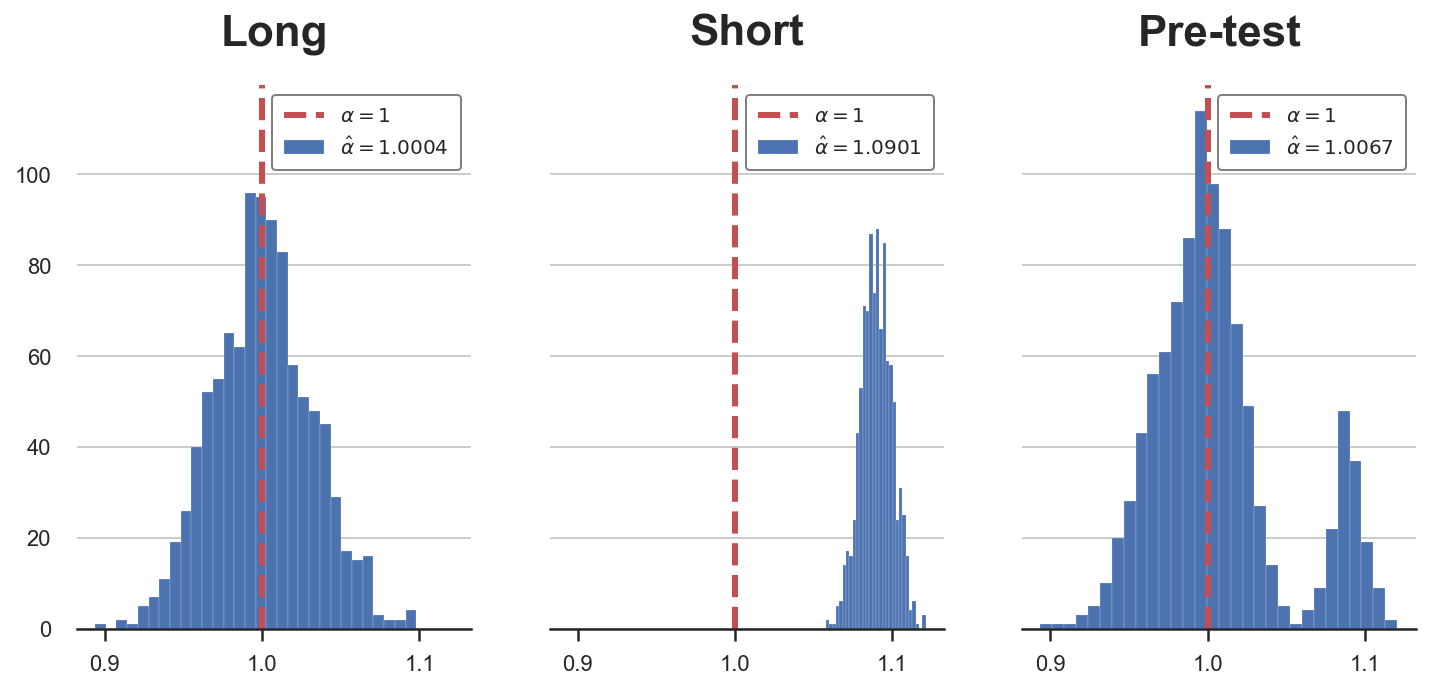

In [7]:
plot_alphas(alphas, true_alpha=1)

In the plot above, I have depicted the estimated coefficients, across simulations, for the different regression specifications. 

As we can see from the first plot, if we were always running the **long regression**, our estimator $\hat \alpha_{long}$ would be unbiased and normally distributed. However, if we were always running the **short regression** (second plot), our estimator $\hat \alpha_{short}$ would be **biased**.

The **pre-testing** procedure generates an estimator $\hat \alpha_{pretest}$ that is a mix of the two: most of the times we select the correct specification, the long regression, but sometimes the pre-test fails to reject the null hypothesis of no effect of `past sales` on `sales`, $H_0 : \beta = 0$, and we select the incorrect specification, running the short regression.

Importantly, the pre-testing procedure **does not generate a biased estimator**. As we can see in the last plot, the estimated coefficient is very close to the true value, 1. The reason is that most of the time, the number of times we select the *short* regression is sufficiently small not to introduce bias, but not small enough to have valid inference.

Indeed, **pre-testing distorts inference**: the distribution of the estimator $\hat \alpha_{pretest}$ is not normal anymore, but bimodal. The **consequence** is that our confidence intervals for $\alpha$ are going to have the wrong coverage (contain the true effect with a different probability than the claimed one).

## When is pre-testing a problem?

The problem of pre-testing arises because of the bias generated by running the short regression: [**omitted variable bias (OVB)**](https://towardsdatascience.com/344ac1477699). In you are not familiar with OVB, I have written a [short introduction here](https://towardsdatascience.com/344ac1477699). In general however, we can express the omitted variable bias introduced by regressing $Y$ on $D$ ignoring $X$ as

$$
\text{OVB} = \beta \delta \qquad \text{ where } \qquad \beta := \frac{Cov(X, Y)}{Var(X)}, \quad \delta := \frac{Cov(D, X)}{Var(D)}
$$

Where $\beta$ is the effect of $X$ (`past sales` in our example) on $Y$ (`sales`) and $\delta$ is the effect of $D$ (`ads`) on $X$.

Pre-testing is a **problem** if

1. We run the short regression instead of the long one *and*
2. The effect of the bias is sensible

What can help improving (1), i.e. the probability of correctly rejecting the null hypothesis of zero effect of `past sales`, $H_0 : \beta = 0$? The answer is simple: a **bigger sample size**. If we have more observations, we can more precisely estimate $\beta$ and it is going to be less likely that we commit a [type 2 error](https://en.wikipedia.org/wiki/Type_I_and_type_II_errors) and run the short regression instead of the long one.

Let's simulate the estimated coefficient $\hat \alpha$ under different sample sizes. Remember that the sample size used until now is $N=1000$.

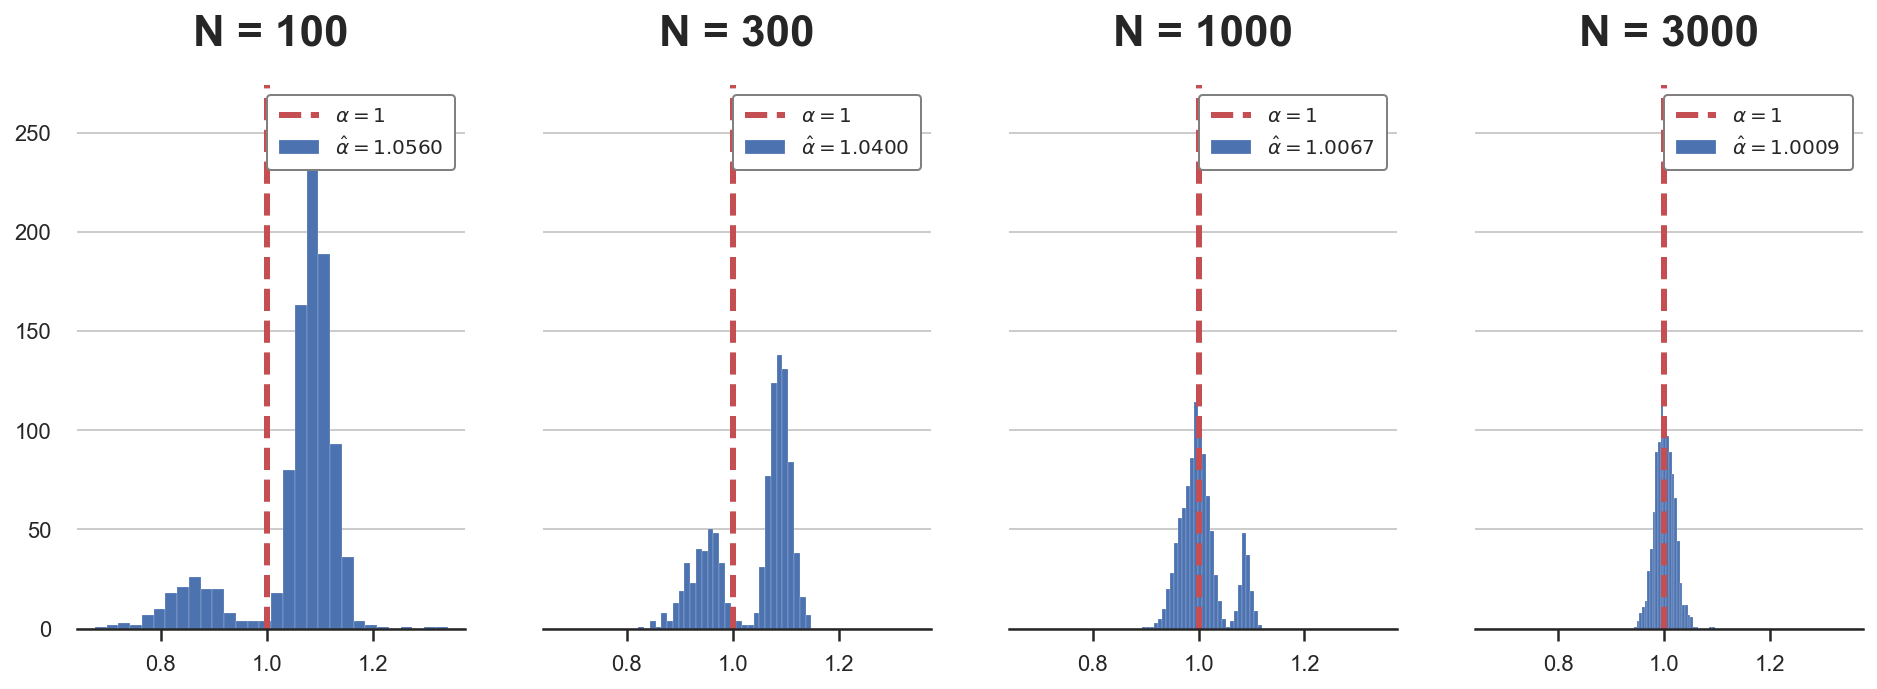

In [8]:
Ns = [100,300,1000,3000]
alphas = {f'N = {n:.0f}':  pre_testing(N=n)['Pre-test'] for n in Ns}
plot_alphas(alphas, true_alpha=1)

As we can see from the plots, as the sample size increases (left to right), the bias decreases and the distribution of the estimator $\hat \alpha_{pretest}$ converges to a normal distribution.

What happens instead if the value of $\beta$ was different? It is probably going to affect point (2) in the previous paragraph, but how?

- If $\beta$ is **very small**, it is going to be hard to detect it, and we will often end up running the *short* regression, introducing a bias. However, if $\beta$ is very small, it also implies that the **magnitude of the bias** is small and therefore it is not going to affect our estimate of $\alpha$ much

- If $\beta$ is **very big**, it is going to be easy to detect and we will often end up running the *long* regression, avoiding the bias (which would have been very big though). 

Let's simulate the estimated coefficient $\hat \alpha$ under different values of $\beta$. The true value used until now was $\beta = 0.3$.

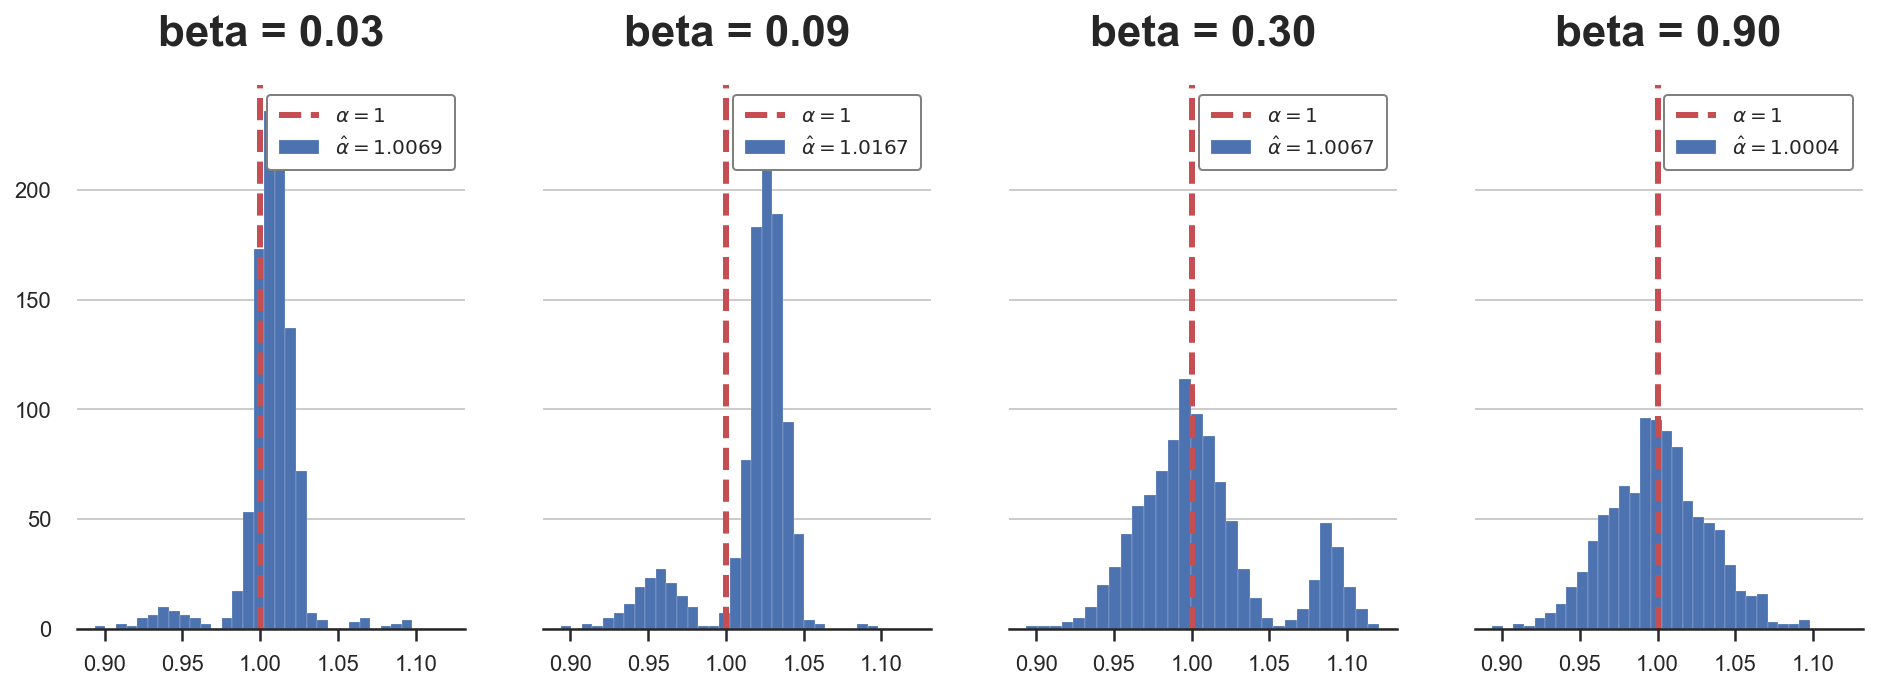

In [9]:
betas = 0.3 * np.array([0.1,0.3,1,3])
alphas = {f'beta = {b:.2f}':  pre_testing(b=b)['Pre-test'] for b in betas}
plot_alphas(alphas, true_alpha=1)

As we can see from the plots, as the value of $\beta$ increases, the bias first appears and then disappears. When $\beta$ is small (left plot), we often choose the short regression, but the bias is small and the average estimate is very close to the true value. For intermediate values of $\beta$, the bias is sensible and it has a clear effect on inference. Lastly, for large values of $\beta$ instead (right plot), we always run the long regression and the bias disappears.

But **when is a coefficient big or small**? And big or small with respect to what? The answer is simple: with respect to the **sample size**, or more accurately, with respect to the inverse of the square root of the sample size, $1 / \sqrt{n}$. The reason is deeply rooted in the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem), but I won't cover it here.

The idea is easier to show than to explain, so let's repeat the same simulation as above, but now we will increase both the coefficient and the sample size at the same time.

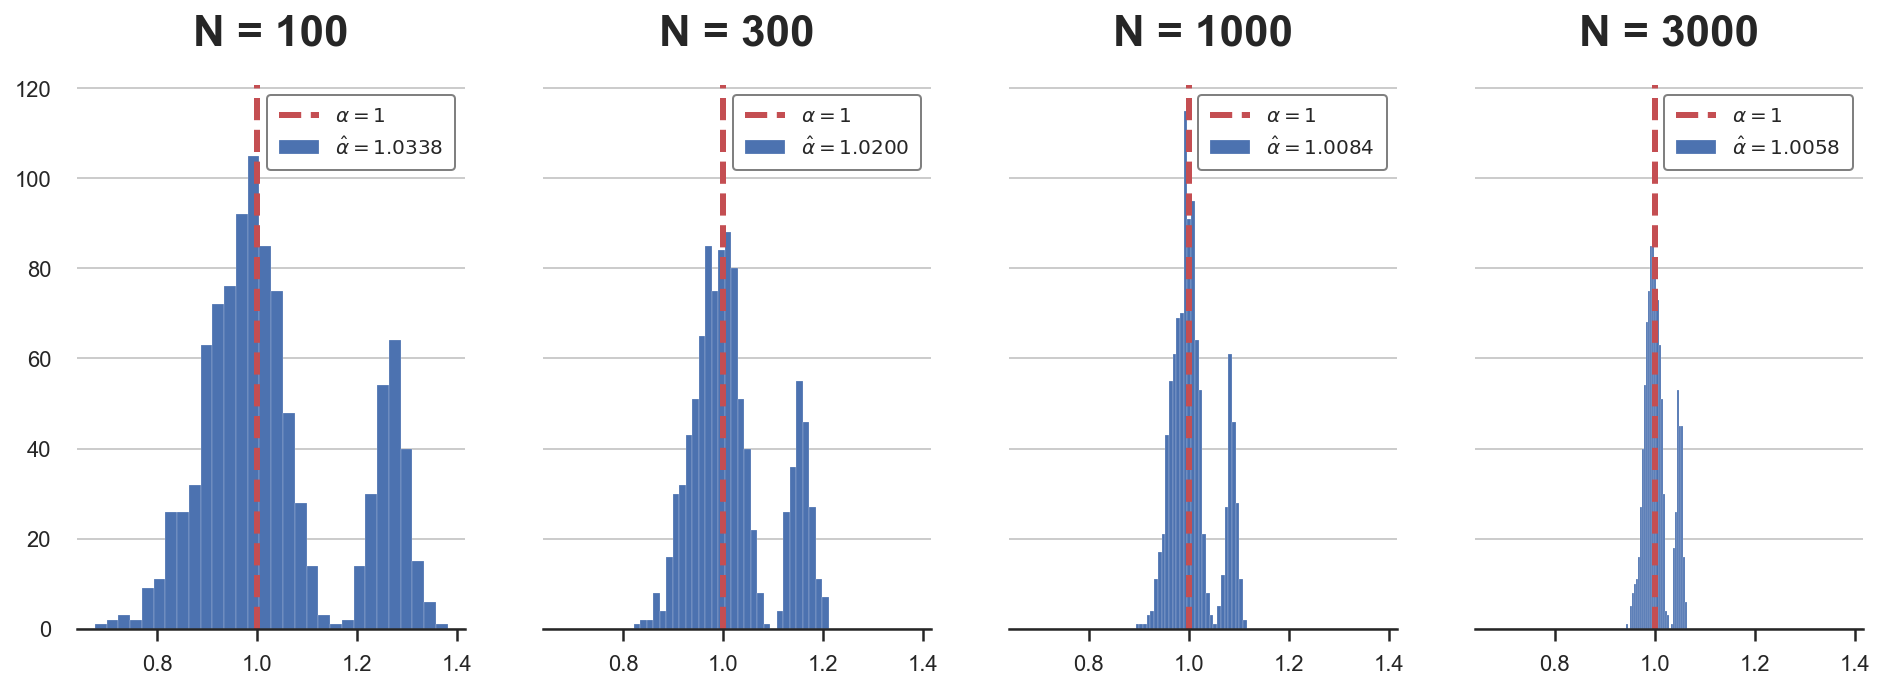

In [10]:
betas = 0.3 * 30 / np.sqrt(Ns)
alphas = {f'N = {n:.0f}':  pre_testing(b=b, N=n)['Pre-test'] for n,b in zip(Ns,betas)}
plot_alphas(alphas, true_alpha=1)

As we can see, now that $\beta$ is proportional to $1 / \sqrt{n}$, the distortion is not going away, not matter the sample size. Therefore, inference will always be wrong.

While a coefficient that depends on the sample size might sound **not intuitive**, it captures well the idea of **magnitude** in a world where we do inference relying on asymptotic results, first among all the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem). In fact, the Central Limit Theorem relieas on an infinitely large sample size. However, with an infinite amount of data, no coefficient is small and any non-zero effect is detected with certainty.

## Pre-Testing and Machine Learning

So far we talked about a linear regression with only 2 variables. Where is the **machine learning** we were promised? 

Usually we do not have just one control variable (or confounder), but many. Moreover, we might want to be flexible with respect to the functional form through which these control variables enter the model. In general, we will assume the following model:

$$
Y = \alpha D + g_0(X) + u
\newline
D = m_0(X) + v
$$

Where the effect of interest is still $\alpha$, $X$ is potentially high dimensional and we do not take a stand on the functional form through which $X$ influences $D$ or $Y$. 

In this setting, it is natural to use a machine learning algorithm to estimate $g_0$ and $m_0$. However, machine learning algorithms usually introduce a **regularization bias** that is comparable to pre-testing. 

Possibly, the "simplest" way to think about it is [Lasso](https://en.wikipedia.org/wiki/Lasso_(statistics)). Lasso is linear in $X$, with a penalization term that effectively just performs the variable selection we discussed above. Therefore, if we were to use Lasso of $X$ and $D$ on $Y$ we would be introducing regularization bias and inference would be distorted. The same goes for more complex algorithms.

Lastly, you might still wonder "why is the model linear in the treatment variable $D$?". Doing inference is much easier in linear model, not only for computational reasons but also for interpretation. Moreover, if the treatment $D$ is binary, the linear functional form is without loss of generality. A stronger assumption is the additive separability of $D$ and $g(X)$.

## Conclusion

In this post, I have tried to explain how does regularization bias emerges and why it can the an issue in causal inference. This problem is inherently related to settings with many control variables or where we would like to have a model-free (i.e. non-parametric) when controlling for confounders. These are exactly the settings in which machine learning algorithms can be useful.

In the next post, I will cover a simple and yet incredibly powerful solution to this problem: double-debiased machine learning. 

### References

[1] A. Belloni, D. Chen, V. Chernozhukov, C. Hansen, [Sparse Models and Methods for Optimal Instruments With an Application to Eminent Domain](https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA9626) (2012), *Econometrica*.

[2] A. Belloni, V. Chernozhukov, C. Hansen, [Inference on treatment effects after selection among high-dimensional controls](https://academic.oup.com/restud/article-abstract/81/2/608/1523757) (2014), *The Review of Economic Studies*.

[3] V. Chernozhukov, D. Chetverikov, M. Demirer, E. Duflo, C. Hansen, W. Newey, J. Robins, [Double/debiased machine learning for treatment and structural parameters](https://academic.oup.com/ectj/article/21/1/C1/5056401) (2018), *The Econometrics Journal*.

### Related Articles

- [Understanding Omitted Variable Bias](https://towardsdatascience.com/344ac1477699)
- [Understanding The Frisch-Waugh-Lovell Theorem](https://towardsdatascience.com/59f801eb3299)
- [DAGs and Control Variables](https://towardsdatascience.com/b63dc69e3d8c)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/pretest.ipynb